before executing this notebook, execute the following script to have all the data `.\shell_scripts\entropy_study.ps1`

In [1]:
%load_ext autoreload
%autoreload 2

INF = 1e30

import os
from os import path


# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "BertPlausibilityStudy":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm
from torch_set_up import DEVICE
from training_bert import BertNli
from DataModules.SnliDM import ESNLIDataModule
from notebooks.plots_utils import default_plot_colormap

### The metrics

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from notebooks.inference_metrics import *

### Special Render for the Metrics

In [3]:
from notebooks.plausibility_visu import hightlight_txt # function to highlight the text
from notebooks.plots_utils import normalize_attention
from IPython.display import display, HTML

def html_render(model_outputs):
    html = ''

    table_len = len(model_outputs['all_layers']['AUC'])
    for i in range(table_len):
        html += '<table>'
        html += '<tr><th></th>' # One xtra head for model's name
        for column_name in model_outputs['all_layers'].keys():
            html+= '<th>'+ column_name +'</th>'
        html += ' </tr>'
        for name, model_content in model_outputs.items():
            html += '<tr>'
            html += '<td><b>' + name + '</b></td>'

            for k, output in model_content.items():
                displ = output[i] if output is not None else 'N/A'
                if isinstance(displ, float):
                    displ = str(round(displ, 3))
                html += '<td>' + displ + '</td>'

            html += '</tr>'

        html += '</table>'
    return html

### Create the figure to sum up all the metrics

In [4]:
%%capture
fig, axes = plt.subplots(8, 3, figsize = (30, 40))
plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.8)

# set the limits for the axes
y_lims = [(0.5, 1), (-0.01, 0.3), (-0.01, 0.5) ,(-0.01, 1.01), (-0.01, 0.5), (-0.01, 1.01), (-0.01,0.5), (-0.1,1.1)]
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set_ylim(y_lims[i][0], y_lims[i][1])

### Mean Head agregation

In [5]:
# load the data
import pickle
dir = os.path.join(".cache", "plots", "e_snli", "entropy_study")
with open(os.path.join(dir, "a_true_head_mean.pickle"), "rb") as f:
    a_true = pickle.load(f)
with open(os.path.join(dir, "all_layers_head_mean.pickle"), "rb") as f:
    all_layers = pickle.load(f)
with open(os.path.join(dir, "layers_1_10_head_mean.pickle"), "rb") as f:
    layers_1_10 = pickle.load(f)
with open(os.path.join(dir, "layers_4_10_head_mean.pickle"), "rb") as f:
    layers_4_10 = pickle.load(f)
with open(os.path.join(dir, "layers_5_10_head_mean.pickle"), "rb") as f:
    layers_5_10 = pickle.load(f)
    
a_ones = {}
a_zeros = {}

for k in ["entailement", "neutral", "contradiction"]:
    a_ones[k] = np.array([1.0] * len(a_true[k]))
    a_zeros[k] = np.array([0.0] * len(a_true[k]))

In [6]:
%%capture
with torch.no_grad():
    temp = {}
    for k in ["entailement", "neutral", "contradiction"]:
        display(HTML(f'<h4>metric for the label : {k}</h4>'))
        metric_output = {}
        
        metric_output["all_layers"] = {
            "AUC": [roc_auc_score(a_true[k],all_layers[k])],
            "Jaccard": [scalar_jaccard(a_true[k], all_layers[k])],
            "AUPRC" : [average_precision_score(a_true[k], all_layers[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], all_layers[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], all_layers[k])],
            "Precision (fixed tr)": [precision(a_true[k], all_layers[k])],
            "Recall (fixed tr)": [recall(a_true[k], all_layers[k])],
            "Entropy" : all_layers["entropy"][k]
            
        }

        metric_output["layers_1_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_1_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_1_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_1_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_1_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_1_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_1_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_1_10[k])],
            "Entropy" : layers_1_10["entropy"][k]
        }

        metric_output["layers_4_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_4_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_4_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_4_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_4_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_4_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_4_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_4_10[k])],
            "Entropy" : layers_4_10["entropy"][k]
        }

        metric_output["layers_5_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_5_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_5_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_5_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_5_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_5_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_5_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_5_10[k])],
            "Entropy" : layers_5_10["entropy"][k]
        }
        
        metric_output["baseline 1"] = {
            "AUC": [roc_auc_score(a_true[k],a_ones[k])],
            "Jaccard": [scalar_jaccard(a_true[k], a_ones[k])],
            "AUPRC" : [average_precision_score(a_true[k], a_ones[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], a_ones[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], a_ones[k])],
            "Precision (fixed tr)": [precision(a_true[k], a_ones[k])],
            "Recall (fixed tr)": [recall(a_true[k], a_ones[k])],
            "Entropy" : [0.0]
        }
        
        metric_output["baseline 0"] = {
            "AUC": [roc_auc_score(a_true[k],a_zeros[k])],
            "Jaccard": [scalar_jaccard(a_true[k], a_zeros[k])],
            "AUPRC" : [average_precision_score(a_true[k], a_zeros[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], a_zeros[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], a_zeros[k])],
            "Precision (fixed tr)": [precision(a_true[k], a_zeros[k])],
            "Recall (fixed tr)": [recall(a_true[k], a_zeros[k])],
            "Entropy" : [0.0]
        }
        
        temp[k] = metric_output.copy()

In [7]:
%%capture
# complete the graphs
metrics = list(temp["entailement"]["all_layers"].keys())

# set the titles
cols = ["Head means", "Head Sum", "Mean EVW"]
rows = metrics.copy()

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=60, fontsize=15, labelpad=20)

for id_m, m in enumerate(metrics):
    ax = axes[id_m, 0]
    for label in ["entailement", "neutral", "contradiction"]:
        buff = []
        for agreg in temp[label]:
            buff.append(temp[label][agreg][m][0])
            
        x = [1,2,3,4,5,6]
        ax.scatter(x, buff, label=label)
        ax.set_xticks(x)
        ax.set_xticklabels(list(temp[label].keys()),fontsize = 15, rotation=80)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 10})
        

plt.legend()

### The sum agregation

In [8]:
# load the data
import pickle
dir = os.path.join(".cache", "plots", "e_snli", "entropy_study")
with open(os.path.join(dir, "a_true_sum.pickle"), "rb") as f:
    a_true = pickle.load(f)
with open(os.path.join(dir, "all_layers_sum.pickle"), "rb") as f:
    all_layers = pickle.load(f)
with open(os.path.join(dir, "layers_1_10_sum.pickle"), "rb") as f:
    layers_1_10 = pickle.load(f)
with open(os.path.join(dir, "layers_4_10_sum.pickle"), "rb") as f:
    layers_4_10 = pickle.load(f)
with open(os.path.join(dir, "layers_5_10_sum.pickle"), "rb") as f:
    layers_5_10 = pickle.load(f)
    
a_ones = {}
a_zeros = {}

for k in ["entailement", "neutral", "contradiction"]:
    a_ones[k] = np.array([1.0] * len(a_true[k]))
    a_zeros[k] = np.array([0.0] * len(a_true[k]))

In [9]:
%%capture
with torch.no_grad():
    temp = {}
    for k in ["entailement", "neutral", "contradiction"]:
        display(HTML(f'<h4>metric for the label : {k}</h4>'))
        metric_output = {}
        
        metric_output["all_layers"] = {
            "AUC": [roc_auc_score(a_true[k],all_layers[k])],
            "Jaccard": [scalar_jaccard(a_true[k], all_layers[k])],
            "AUPRC" : [average_precision_score(a_true[k], all_layers[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], all_layers[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], all_layers[k])],
            "Precision (fixed tr)": [precision(a_true[k], all_layers[k])],
            "Recall (fixed tr)": [recall(a_true[k], all_layers[k])],
            "Entropy" : all_layers["entropy"][k]
            
        }

        metric_output["layers_1_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_1_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_1_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_1_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_1_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_1_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_1_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_1_10[k])],
            "Entropy" : layers_1_10["entropy"][k]
        }

        metric_output["layers_4_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_4_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_4_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_4_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_4_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_4_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_4_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_4_10[k])],
            "Entropy" : layers_4_10["entropy"][k]
        }

        metric_output["layers_5_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_5_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_5_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_5_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_5_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_5_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_5_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_5_10[k])],
            "Entropy" : layers_5_10["entropy"][k]
        }
        
        metric_output["baseline 1"] = {
            "AUC": [roc_auc_score(a_true[k],a_ones[k])],
            "Jaccard": [scalar_jaccard(a_true[k], a_ones[k])],
            "AUPRC" : [average_precision_score(a_true[k], a_ones[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], a_ones[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], a_ones[k])],
            "Precision (fixed tr)": [precision(a_true[k], a_ones[k])],
            "Recall (fixed tr)": [recall(a_true[k], a_ones[k])],
            "Entropy" : [0.0]
        }
        
        metric_output["baseline 0"] = {
            "AUC": [roc_auc_score(a_true[k],a_zeros[k])],
            "Jaccard": [scalar_jaccard(a_true[k], a_zeros[k])],
            "AUPRC" : [average_precision_score(a_true[k], a_zeros[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], a_zeros[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], a_zeros[k])],
            "Precision (fixed tr)": [precision(a_true[k], a_zeros[k])],
            "Recall (fixed tr)": [recall(a_true[k], a_zeros[k])],
            "Entropy" : [0.0]
        }
        
        temp[k] = metric_output.copy()

In [10]:
%%capture
# complete the graphs
metrics = list(temp["entailement"]["all_layers"].keys())
for id_m, m in enumerate(metrics):
    ax = axes[id_m, 1]
    for label in ["entailement", "neutral", "contradiction"]:
        buff = []
        for agreg in temp[label]:
            buff.append(temp[label][agreg][m][0])
            
        x = [1,2,3,4,5,6]
        ax.scatter(x, buff, label=label)
        ax.set_xticks(x)
        ax.set_xticklabels(list(temp[label].keys()),fontsize = 15, rotation=80)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 10})

### Mean everywhere

In [11]:
# load the data
import pickle
dir = os.path.join(".cache", "plots", "e_snli", "entropy_study")
with open(os.path.join(dir, "a_true_mean.pickle"), "rb") as f:
    a_true = pickle.load(f)
with open(os.path.join(dir, "all_layers_mean.pickle"), "rb") as f:
    all_layers = pickle.load(f)
with open(os.path.join(dir, "layers_1_10_mean.pickle"), "rb") as f:
    layers_1_10 = pickle.load(f)
with open(os.path.join(dir, "layers_4_10_mean.pickle"), "rb") as f:
    layers_4_10 = pickle.load(f)
with open(os.path.join(dir, "layers_5_10_mean.pickle"), "rb") as f:
    layers_5_10 = pickle.load(f)
    
a_ones = {}
a_zeros = {}

for k in ["entailement", "neutral", "contradiction"]:
    a_ones[k] = np.array([1.0] * len(a_true[k]))
    a_zeros[k] = np.array([0.0] * len(a_true[k]))

In [12]:
%%capture
with torch.no_grad():
    temp = {}
    for k in ["entailement", "neutral", "contradiction"]:
        display(HTML(f'<h4>metric for the label : {k}</h4>'))
        metric_output = {}
        
        metric_output["all_layers"] = {
            "AUC": [roc_auc_score(a_true[k],all_layers[k])],
            "Jaccard": [scalar_jaccard(a_true[k], all_layers[k])],
            "AUPRC" : [average_precision_score(a_true[k], all_layers[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], all_layers[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], all_layers[k])],
            "Precision (fixed tr)": [precision(a_true[k], all_layers[k])],
            "Recall (fixed tr)": [recall(a_true[k], all_layers[k])],
            "Entropy" : all_layers["entropy"][k]
            
        }

        metric_output["layers_1_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_1_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_1_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_1_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_1_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_1_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_1_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_1_10[k])],
            "Entropy" : layers_1_10["entropy"][k]
        }

        metric_output["layers_4_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_4_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_4_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_4_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_4_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_4_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_4_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_4_10[k])],
            "Entropy" : layers_4_10["entropy"][k]
        }

        metric_output["layers_5_10"] = {
            "AUC": [roc_auc_score(a_true[k],layers_5_10[k])],
            "Jaccard": [scalar_jaccard(a_true[k], layers_5_10[k])],
            "AUPRC" : [average_precision_score(a_true[k], layers_5_10[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], layers_5_10[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], layers_5_10[k])],
            "Precision (fixed tr)": [precision(a_true[k], layers_5_10[k])],
            "Recall (fixed tr)": [recall(a_true[k], layers_5_10[k])],
            "Entropy" : layers_5_10["entropy"][k]
        }
        
        metric_output["baseline 1"] = {
            "AUC": [roc_auc_score(a_true[k],a_ones[k])],
            "Jaccard": [scalar_jaccard(a_true[k], a_ones[k])],
            "AUPRC" : [average_precision_score(a_true[k], a_ones[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], a_ones[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], a_ones[k])],
            "Precision (fixed tr)": [precision(a_true[k], a_ones[k])],
            "Recall (fixed tr)": [recall(a_true[k], a_ones[k])],
            "Entropy" : [0.0]
        }
        
        metric_output["baseline 0"] = {
            "AUC": [roc_auc_score(a_true[k],a_zeros[k])],
            "Jaccard": [scalar_jaccard(a_true[k], a_zeros[k])],
            "AUPRC" : [average_precision_score(a_true[k], a_zeros[k])],
            "AU - Precision" : [au_precision_curve(a_true[k], a_zeros[k])],
            "AU - Recall" : [au_recall_curve(a_true[k], a_zeros[k])],
            "Precision (fixed tr)": [precision(a_true[k], a_zeros[k])],
            "Recall (fixed tr)": [recall(a_true[k], a_zeros[k])],
            "Entropy" : [0.0]
        }
        
        temp[k] = metric_output.copy()

In [13]:
print("contradiction", temp["contradiction"]["layers_4_10"]["AUC"][0])
print("neutral", temp["neutral"]["layers_4_10"]["AUC"][0])
print("entailement", temp["entailement"]["layers_4_10"]["AUC"][0])

contradiction 0.7265957000691315
neutral 0.7021452369326178
entailement 0.6564229986712011


In [14]:
%%capture
# complete the graphs
metrics = list(temp["entailement"]["all_layers"].keys())
for id_m, m in enumerate(metrics):
    ax = axes[id_m, 2]
    for label in ["entailement", "neutral", "contradiction"]:
        buff = []
        for agreg in temp[label]:
            buff.append(temp[label][agreg][m][0])
            
        x = [1,2,3,4,5,6]
        ax.scatter(x, buff, label=label)
        ax.set_xticks(x)
        ax.set_xticklabels(list(temp[label].keys()),fontsize = 15, rotation=80)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 10})
        
plt.legend(prop={"size":10})
plt.savefig(os.path.join(os.getcwd(),".cache", "plots", "e_snli", "entropy_study", "metrics_graph.png"))

In [15]:
fig.savefig(os.path.join(os.getcwd(),".cache", "plots", "e_snli", "entropy_study", "metrics_graph.png"))

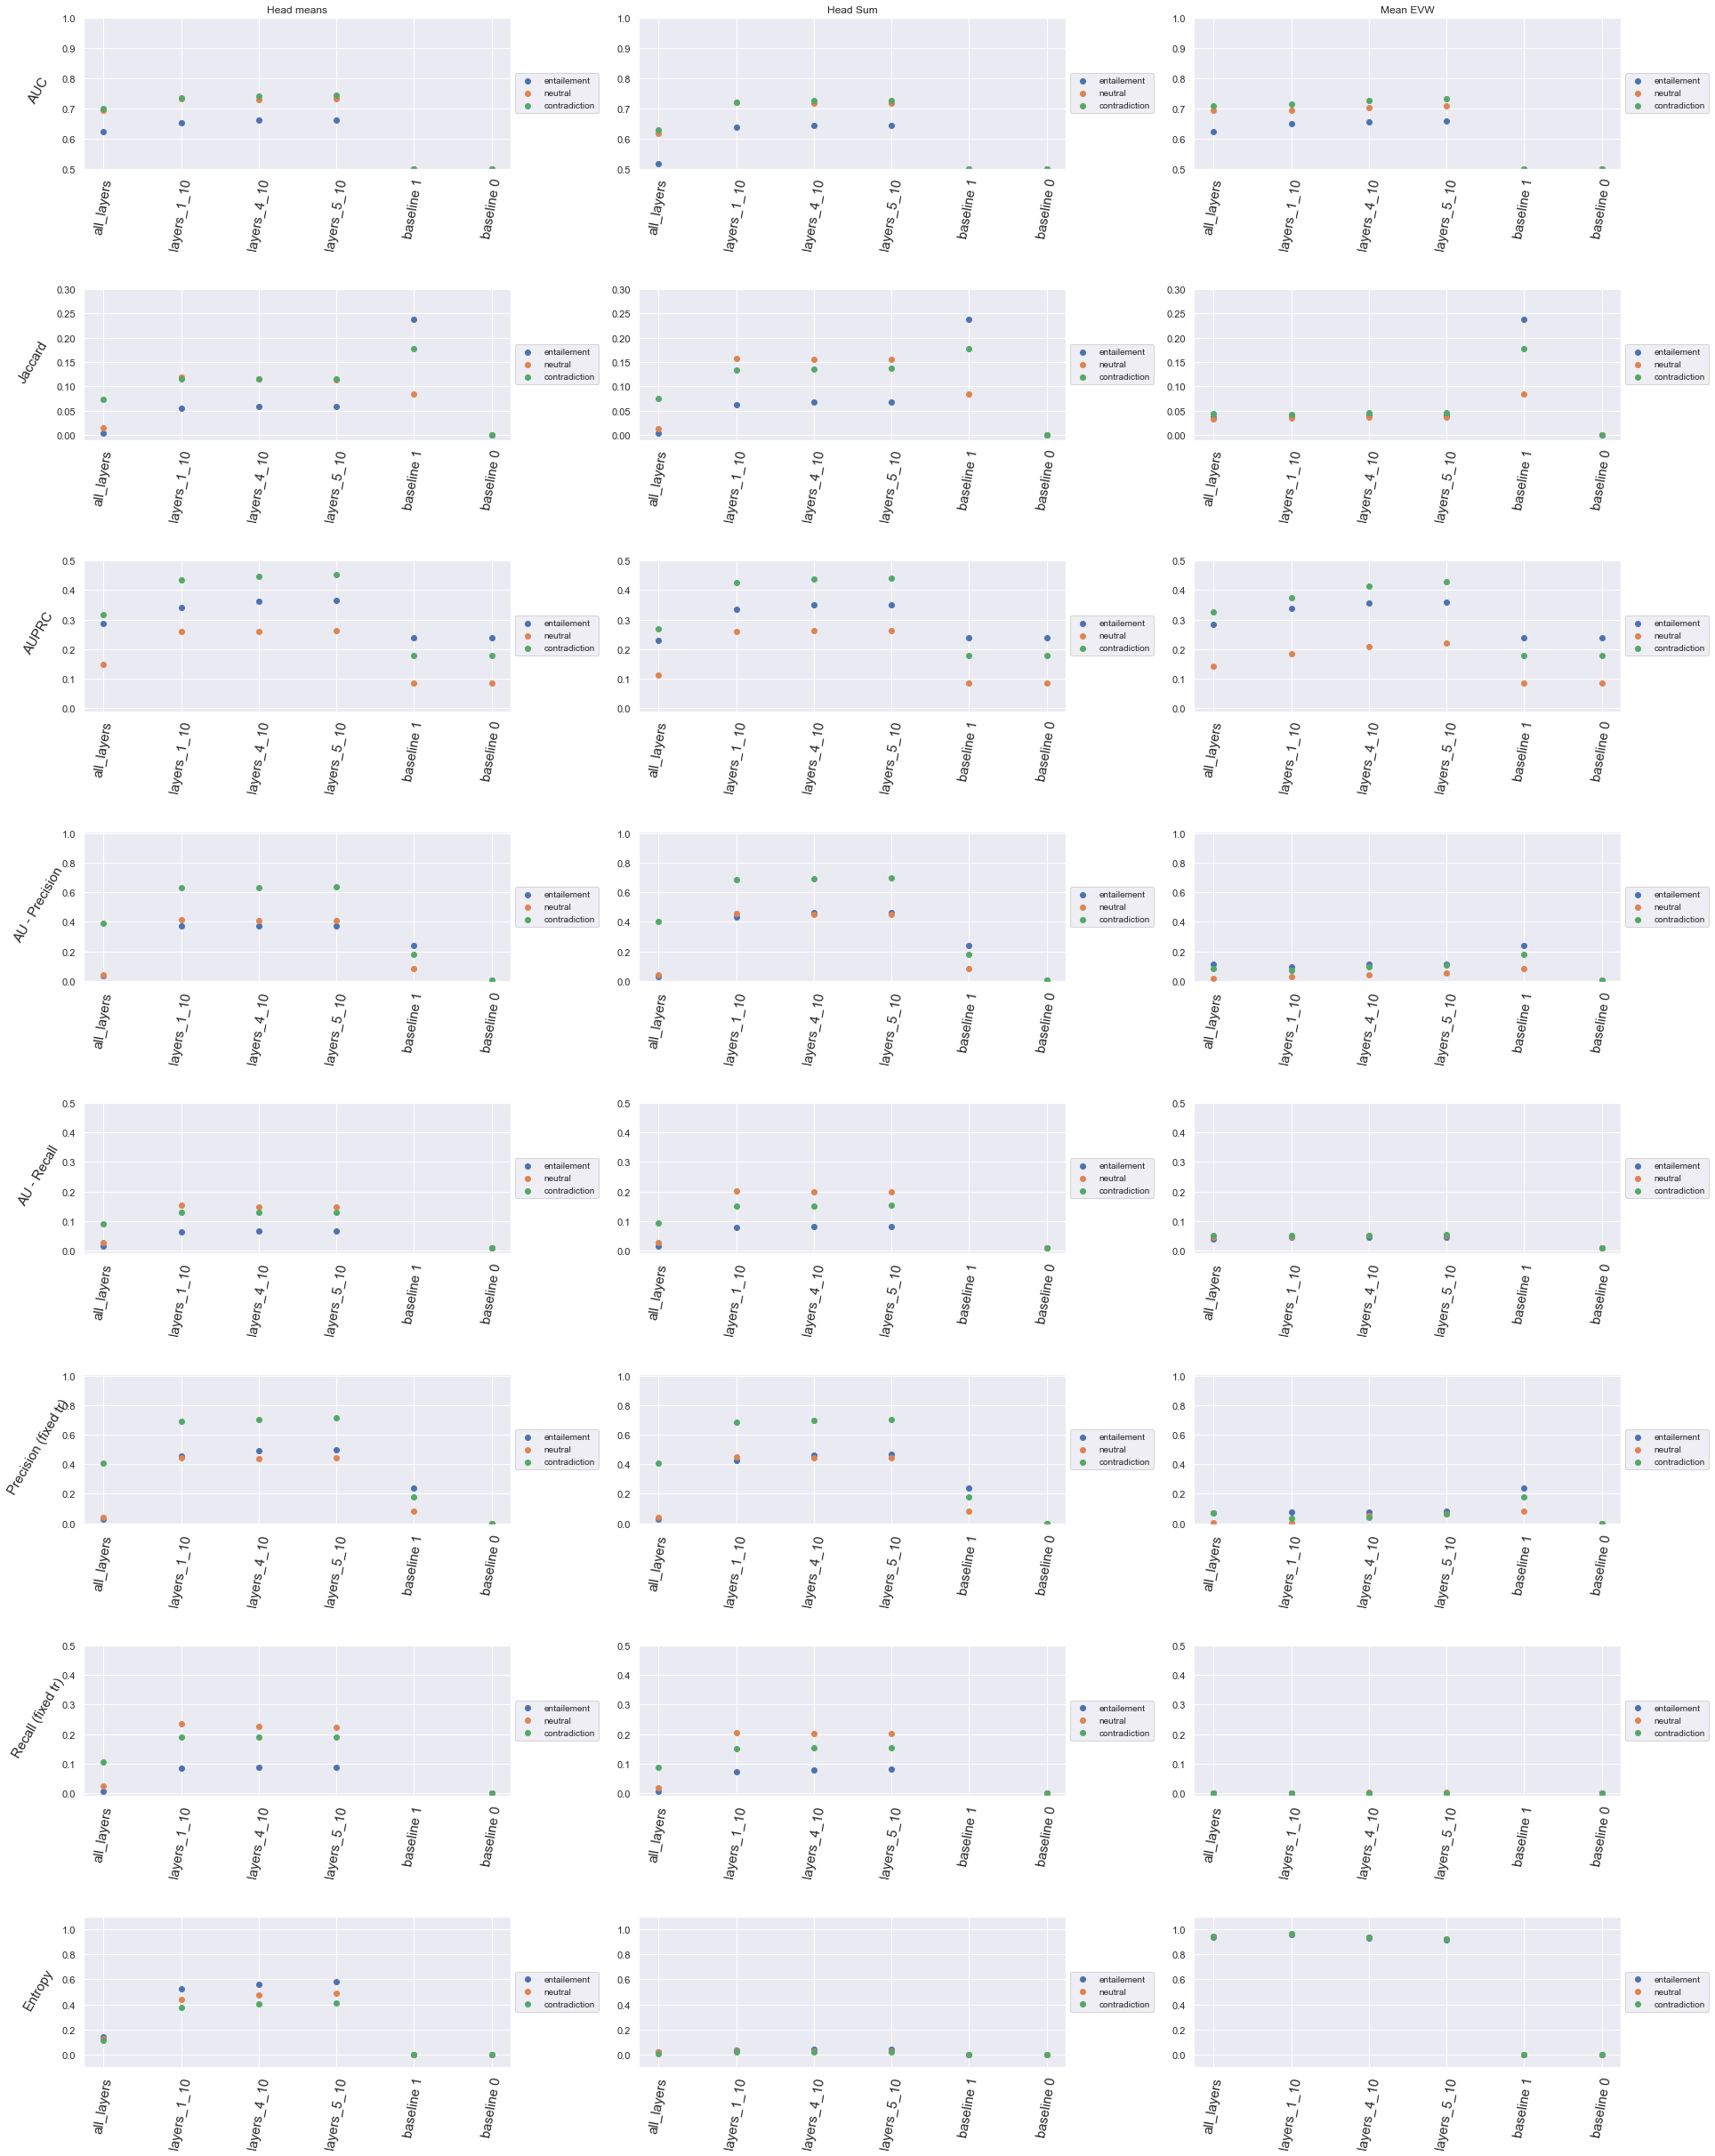

In [16]:
fig

In [20]:
for i in [0, 1, 2, 5, 6,7]:
    for j in range(3):
        axes[i,j].remove()
        
fig.set_size_inches(35, 30)
fig.subplots_adjust(
    top=0.9,
    bottom=0,
    left=0.042,
    right=0.981,
    hspace=0.2,
    wspace=0.2
)

plt.setp(axes[3,0].get_xticklabels(), visible=False)
plt.setp(axes[3,1].get_xticklabels(), visible=False)
plt.setp(axes[3,2].get_xticklabels(), visible=False)

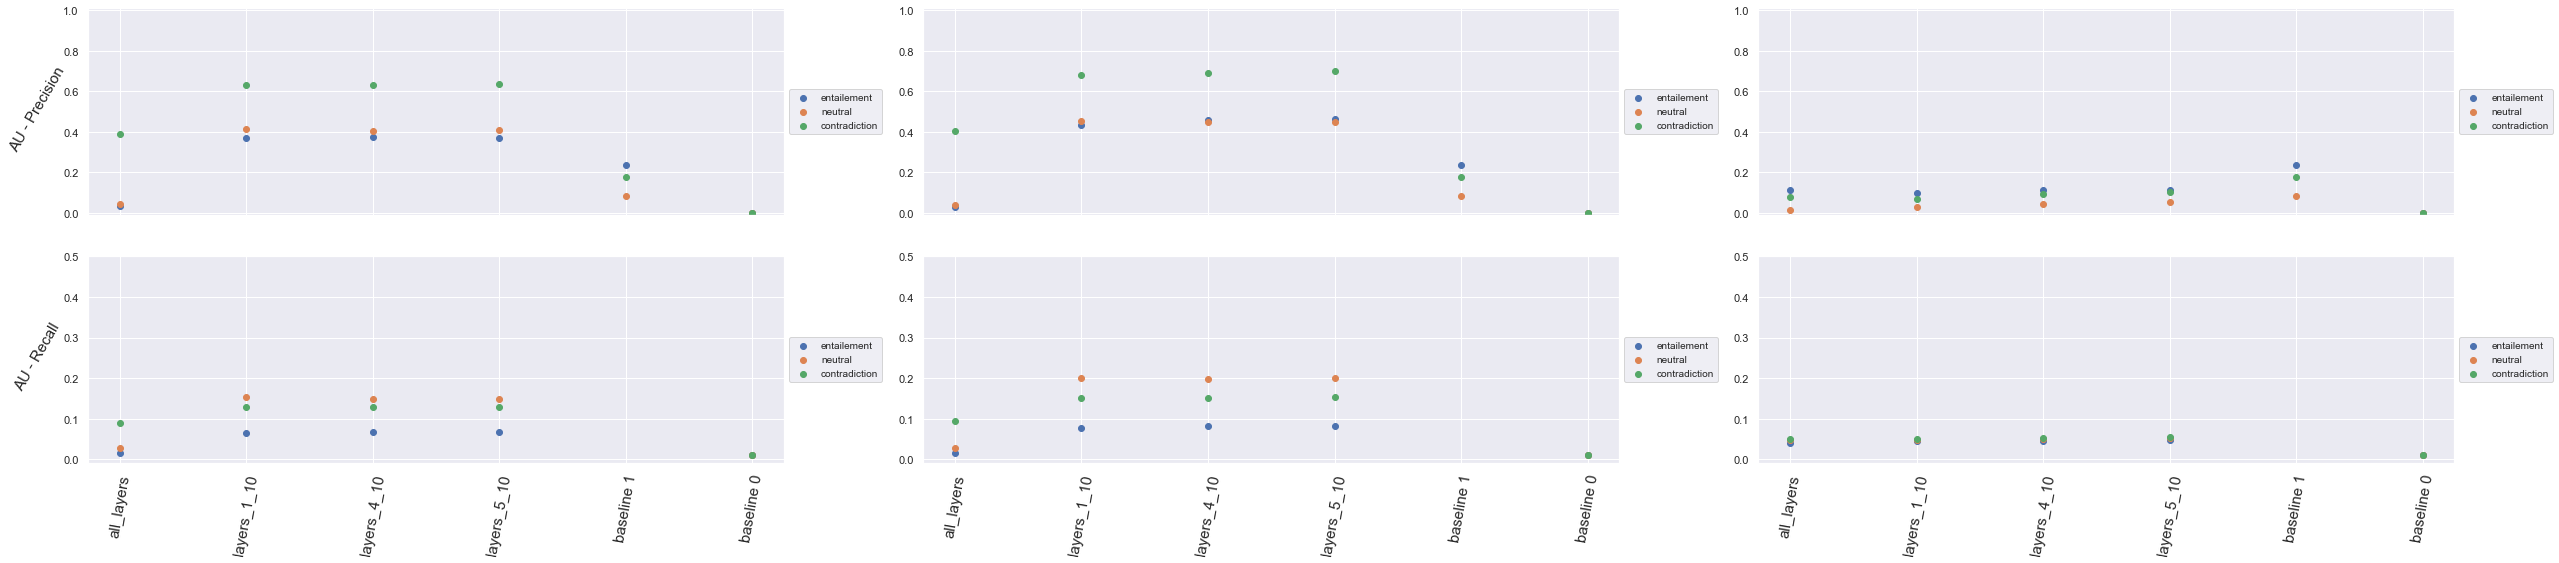

In [21]:
fig

In [22]:
fig.savefig(os.path.join(os.getcwd(),".cache", "plots", "e_snli", "entropy_study", "pre_rc_graph.png"))